### Set Up

In [9]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [10]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 2

### Load Data

In [12]:
def get_data(path):
    df = pd.read_csv(path)
    df.columns = ['free_text', 'label_id']
    
    return df

train_df = get_data('data/train.csv')
valid_df = get_data('data/dev.csv')
test_df = get_data('data/test.csv')

train_df = train_df.dropna(subset=['free_text'])
valid_df = valid_df.dropna(subset=['free_text'])
test_df = test_df.dropna(subset=['free_text'])
# We will use Kfold later
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.label_id)):
    train_df.loc[val_, "kfold"] = fold

In [13]:
train_df.sample(5)

,free_text,label_id,kfold
10832,Ko lẻ bất cứ nước nào nhận lao động nước ngoài...,1,0.0
21490,Con ko xin tiền chi xin được góp công lam tu ...,0,1.0
18175,Mat lon linh ca loc nay choi xuong lam,2,1.0
8888,Sao lại đi làm lộ mặt người ta vậy,0,0.0
23619,"Ngô Tấn Hưng trình Thầy Ba hơn chứ ông, Duke c...",0,1.0


In [14]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26718 entries, 0 to 26717
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   free_text  26718 non-null  object 
 1   label_id   26718 non-null  int64  
 2   kfold      26718 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 626.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6680 entries, 0 to 6679
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   free_text  6680 non-null   object
 1   label_id   6680 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 104.5+ KB


(None, None)

### DataLoader

In [15]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [16]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['free_text']
        text = ' '.join(simple_preprocess(text))
        label = int(row['label_id'])

        return text, label

Text(0.5, 9.444444444444438, 'Token Count')

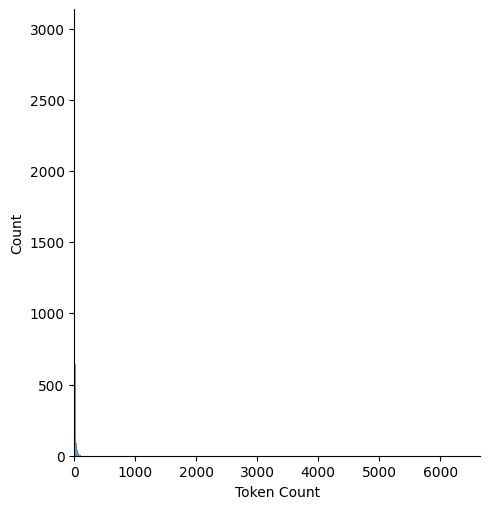

In [17]:
all_data = train_df.free_text.tolist() + test_df.free_text.tolist()

# Ensure all elements in all_data are strings
all_data = [str(text) for text in all_data]

# Preprocess the text
all_data = [' '.join(simple_preprocess(text)) for text in all_data]

# Encode the text using your tokenizer
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]

# Calculate token lengths
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

### Model

In [18]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

### Train & Eval Function

In [19]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)


### Training with K-Fold

In [20]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    return train_loader, valid_loader

In [21]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=0, 
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------
Epoch 1/6
------------------------------
Train Accuracy: 0.8402575043042143 Loss: 0.4783595641840718
Valid Accuracy: 0.8642862489707313 Loss: 0.3914675566005314
Epoch 2/6
------------------------------
Train Accuracy: 0.872969533647728 Loss: 0.3663116566769913
Valid Accuracy: 0.8726701100381764 Loss: 0.35760394643300664
Epoch 3/6
------------------------------
Train Accuracy: 0.8969234224118571 Loss: 0.29621874743816023
Valid Accuracy: 0.8632382663373006 Loss: 0.4074231651918349
Epoch 4/6
------------------------------
Train Accuracy: 0.9157122539112208 Loss: 0.246860922429666
Valid Accuracy: 0.8744666516954861 Loss: 0.44020547781273456
Epoch 5/6
------------------------------
Train Accuracy: 0.9337525263867055 Loss: 0.20107002375496852
Valid Accuracy: 0.8676547645781869 Loss: 0.4510396246240658
Epoch 6/6
------------------------------
Train Accuracy: 0.9433340818923571 Loss: 0.17151731912124746
Valid Accuracy: 0.8683284676996781 Loss: 0.4896489882

In [28]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=3)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [29]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5548
           1       0.49      0.33      0.40       444
           2       0.66      0.47      0.55       688

    accuracy                           0.87      6680
   macro avg       0.69      0.59      0.63      6680
weighted avg       0.86      0.87      0.86      6680



### Visualize Wrong Predicted Label

In [31]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].free_text)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
coin card :3
Predicted: (tan cong) --vs-- Real label: (geht)
--------------------------------------------------
Ôi tuổi thơ
Predicted: (geht) --vs-- Real label: (Binh thuong)
--------------------------------------------------
Thay Ngu
Predicted: (Binh thuong) --vs-- Real label: (tan cong)
--------------------------------------------------
(Y) page này ad nó kiến thức uyên sâu lắm từ xây dựng tài chính y tế cái j n cũng am hiểu =)))) ngu dốt + nhiệt tình = phá hoại k sai bh
Predicted: (Binh thuong) --vs-- Real label: (geht)
--------------------------------------------------
@Anh Nguyen Tuan Đúng rồi hihi
Predicted: (Binh thuong) --vs-- Real label: (geht)
--------------------------------------------------
Lê Khánh An kệ ng ta việc nhà mik là giữ top🙂
Predicted: (Binh thuong) --vs-- Real label: (geht)
--------------------------------------------------
Thích nhất bài chiếc khăn gió ấm 🌬
Predicted: (Binh thuong) --vs-- Real label: (geht)
--

### Inference

In [32]:
def infer(text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')

In [36]:
infer('video nay nhu cut', tokenizer)

Text: video nay nhu cut
Sentiment: Binh thuong


### <center> Thanks for reading 🥰🥰🥰 </center>

### References:

* https://github.com/VinAIResearch/PhoBERT

* https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

* http://nlp.uit.edu.vn/datasets/

* https://www.kaggle.com/code/shoheiazuma/tweet-sentiment-roberta-pytorch/notebook#Model

* https://skimai.com/fine-tuning-bert-for-sentiment-analysis/